In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from jenks import jenks
from datetime import datetime
import numpy as np

## Dataset Preparation

In [2]:
# read dataset
path = 'data13to17Feb2018.csv'
df = pd.read_csv(path, usecols=['Time', 'Source', 'Destination', 'Protocol', 'Length']).dropna()

# keep only the columns that we want
df = df[['Time', 'Length']]

# transform time column to datetime object
df['Time']= pd.to_datetime(df['Time'])

In [3]:
# we want to disregard the records which have as date 1970
df['Year'] = df['Time'].dt.year
df = df[df['Year'] > 1970]
df = df[['Time', 'Length']]

In [4]:
# check how the dataset looks like
df.head()

,Time,Length
0,2019-02-13 02:13:38.346809,152
1,2019-02-13 02:13:38.347297,40
2,2019-02-13 02:13:38.678841,88
3,2019-02-13 02:13:38.679018,40
4,2019-02-13 02:16:38.390502,152


## Get a slice of the whole dataset

In [5]:
sliced_df = df[(df['Time'].dt.day == 13) & (df['Time'].dt.hour > 14) & (df['Time'].dt.hour < 16)]
sliced_df = sliced_df.iloc[800:10800]

#### Plot the sliced dataset

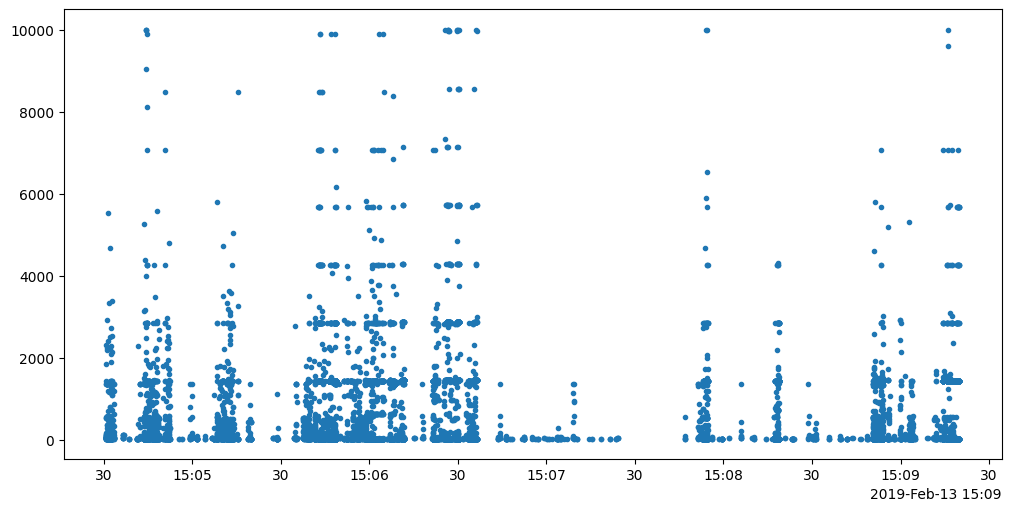

In [6]:
x = sliced_df['Time']
y = sliced_df['Length']

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(x, y, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

## Clustering of the initial dataset

#### Calculate the cluster limits based on the jenks method

In [7]:
cluster_limits = jenks(y, 6)

In [8]:
# function to help up assign clusters
def put_to_cluster(value, cluster_limits):
    cluster_index = 0
    for i in range(len(cluster_limits)):
        upper = cluster_limits[i]
        if value < upper:
            return cluster_index
        cluster_index += 1

In [9]:
# assign records of the sliced dataset in clusters
sliced_df['Bucket'] = sliced_df['Length'].apply(lambda x: put_to_cluster(x, cluster_limits))

#### Plot the sliced dataset with the clusters

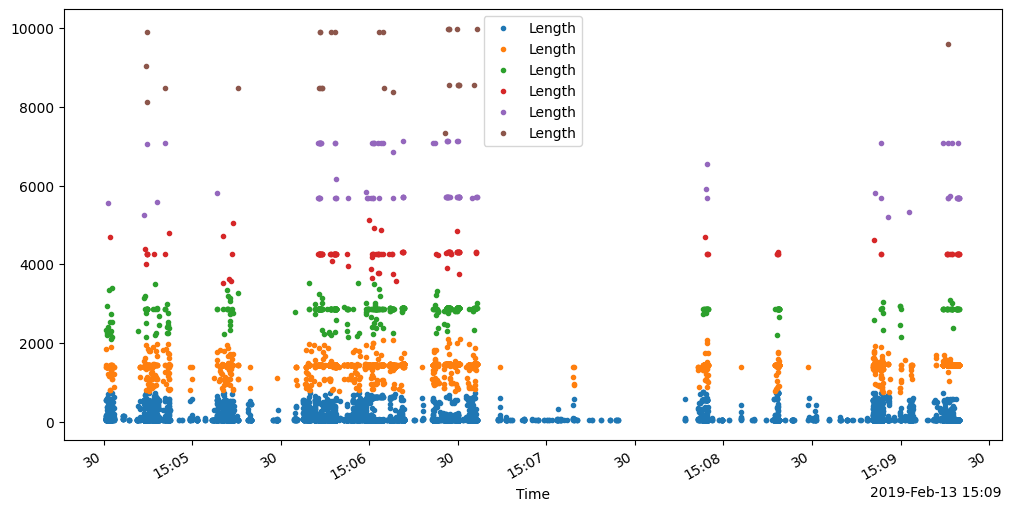

In [10]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sliced_df.reset_index().groupby('Bucket').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

## Concise sampling

In [11]:
# prepare the dataset for sampling
event_list = []
for index, row in sliced_df.iterrows():
    event_list.append(str(index) + ',' + str(row['Time']) + ',' + str(row['Length']))

In [12]:
def concise_sampling(event):
    N = len(event)
    a = 1.1 # We increase T by 10%
    max_size = N / 10

    # 1/T = selection probability
    T = 1

    #// S = Concise Sample
    S = {}
    S_help = {}
    S_help_real_index = {}
    len_S = 0

    for ev in event:
        
        real_idx, idx, val = ev.split(",")
        
        t_real_idx = int(real_idx)
        t_idx = datetime.strptime(idx, '%Y-%m-%d %H:%M:%S.%f')
        t_val = float(val)

        if np.random.random() < 1/T:
            if t_val in S:
                S[t_val] += 1
                S_help[t_val].append(t_idx)
                S_help_real_index[t_val].append(t_real_idx)
            else:
                S_help[t_val] = [t_idx]
                S_help_real_index[t_val] = [t_real_idx]
                S[t_val] = 1
            len_S += 1

    
        # Deletion step, Adjust sample when it gets too large
        
        if len_S> max_size:
            T_prime = a * T
            
            for s in S:
                for _ in range(S[s]):
                    if np.random.random() < 1 - T/T_prime:
                        S[s] -= 1
                        len_S -=1
                        if len(S_help[s]) == 1:
                            S_help[s].pop(0)
                            S_help_real_index[s].pop(0)
                        else:
                            rnd_metric = np.random.randint(0,len(S_help[s])-1)
                            S_help[s].pop(rnd_metric)
                            S_help_real_index[s].pop(rnd_metric)
            
            T = T_prime
    
    real_idx_list = []
    idx_list = []
    res_list = []

    for s in S:
        if S[s] > 0:
            for i in range(S[s]):
                idx_list.append(S_help[s][i])
                real_idx_list.append(S_help_real_index[s][i])
                res_list.append(s)

    return idx_list, res_list, real_idx_list

In [13]:
idx_list, res_list, real_idx_list = concise_sampling(event_list)

## Sampled Dataset

#### Plot without clusters

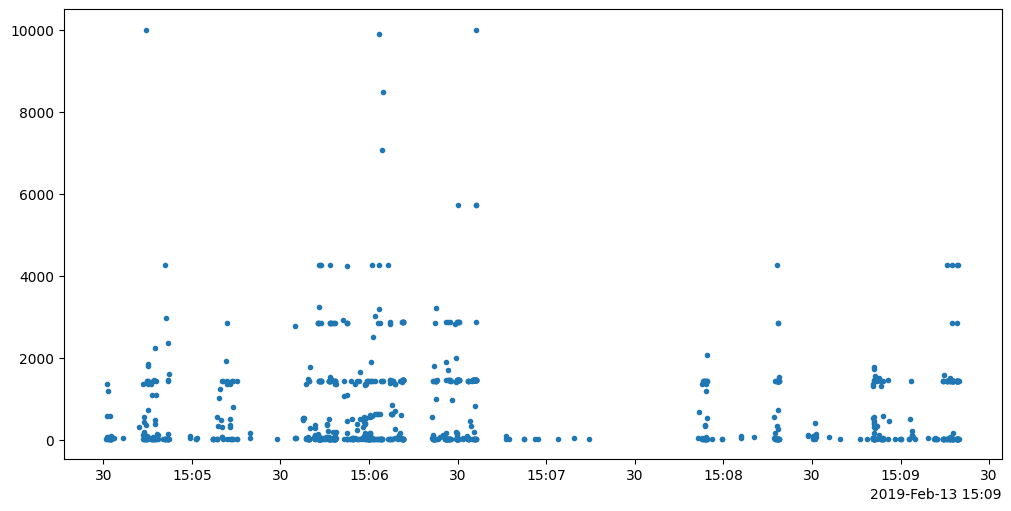

In [14]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(idx_list, res_list, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

### Add the information for the initial clusters C

In [15]:
# create a dataframe of the sliced dataset
sampled_df = pd.DataFrame({'Time':idx_list, 'Length':res_list}, index=real_idx_list)

In [16]:
sampled_with_sliced_df = sampled_df.merge(sliced_df, how = 'left', left_index=True, right_index=True)
sampled_with_sliced_df = sampled_with_sliced_df[['Time_x','Length_x', 'Bucket']]
sampled_with_sliced_df.columns = ['Time', 'Length', 'C_cluster']

In [17]:
sampled_with_sliced_df.head()

,Time,Length,C_cluster
489614,2019-02-13 15:04:31.249432,48.0,1.0
490797,2019-02-13 15:05:01.674848,48.0,1.0
491353,2019-02-13 15:05:19.523667,48.0,1.0
491414,2019-02-13 15:05:34.853119,48.0,1.0
491756,2019-02-13 15:05:41.521643,48.0,1.0


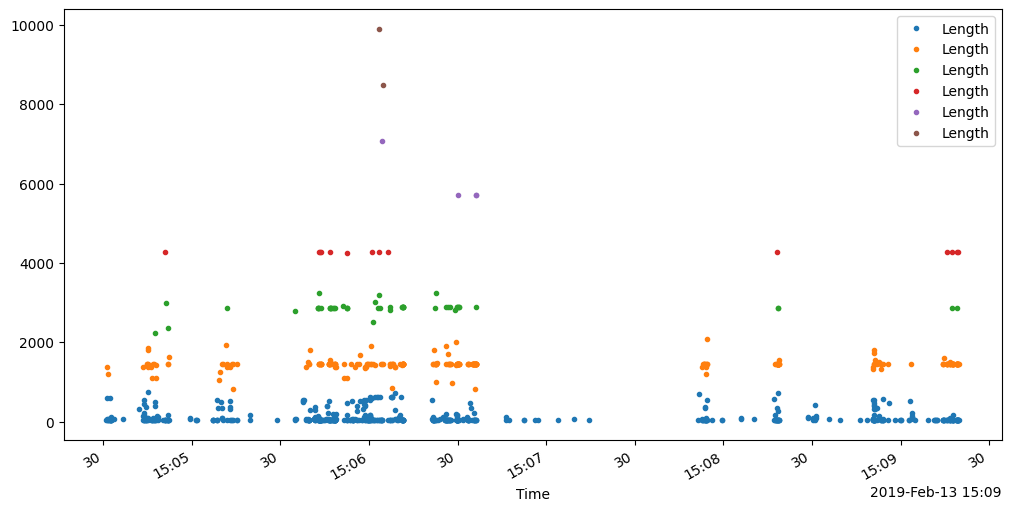

In [18]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sampled_with_sliced_df.reset_index().groupby('C_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

### Prodcuce the new clusters C'

In [19]:
# produce the cluster limits for the sliced dataset
cluster_limits = jenks(res_list, 6)

# apply the new clusters in the sliced dataset
sampled_with_sliced_df['C_prime_cluster'] = sampled_with_sliced_df['Length'].apply(lambda x: put_to_cluster(x, cluster_limits))

In [20]:
# check the sampled dataset
sampled_with_sliced_df.head()

,Time,Length,C_cluster,C_prime_cluster
489614,2019-02-13 15:04:31.249432,48.0,1.0,1.0
490797,2019-02-13 15:05:01.674848,48.0,1.0,1.0
491353,2019-02-13 15:05:19.523667,48.0,1.0,1.0
491414,2019-02-13 15:05:34.853119,48.0,1.0,1.0
491756,2019-02-13 15:05:41.521643,48.0,1.0,1.0


## Plot the new clustering C' in the sliced dataset

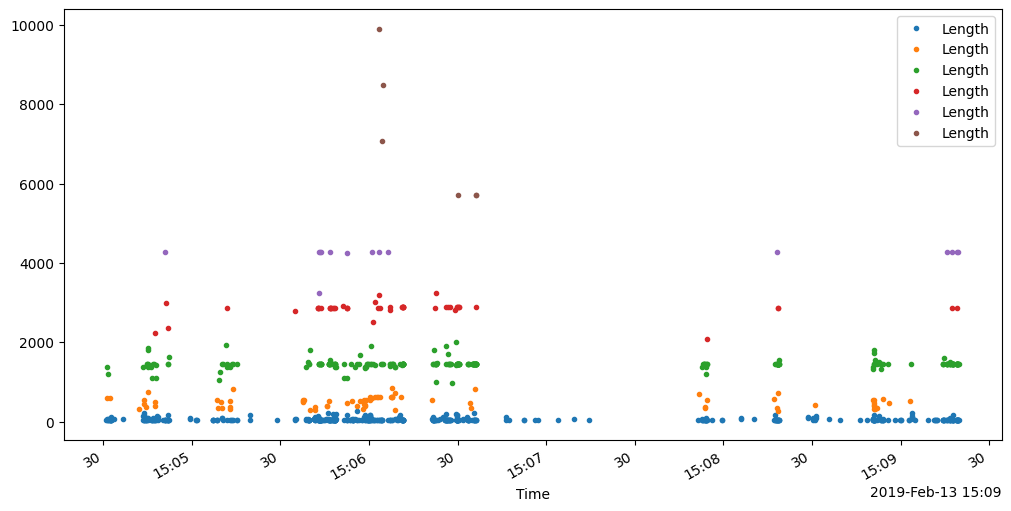

In [21]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sampled_with_sliced_df.reset_index().groupby('C_prime_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

# Cluster Validation

S11 = pairs that are in the same cluster under C and C’

S00 = pairs that are in different clusters under C and C’

S10 = pairs that are in the same cluster under C but in different ones under C’

S01 = pairs that are in different clusters under C but in the same under C’

In [22]:
sampled_with_sliced_df.head()

,Time,Length,C_cluster,C_prime_cluster
489614,2019-02-13 15:04:31.249432,48.0,1.0,1.0
490797,2019-02-13 15:05:01.674848,48.0,1.0,1.0
491353,2019-02-13 15:05:19.523667,48.0,1.0,1.0
491414,2019-02-13 15:05:34.853119,48.0,1.0,1.0
491756,2019-02-13 15:05:41.521643,48.0,1.0,1.0


In [51]:
sampled_with_sliced_df['key1'] = 0
sampled_with_sliced_df['key2'] = 0
sampled_with_sliced_df['index'] = sampled_with_sliced_df.index

In [52]:
cross_joined_df = sampled_with_sliced_df.merge(sampled_with_sliced_df, left_on='key1', right_on='key2', how='outer')
cross_joined_df = cross_joined_df[['index_x', 'index_y', 'C_cluster_x', 'C_prime_cluster_x', 'C_cluster_y', 'C_prime_cluster_y']]
cross_joined_df = cross_joined_df[cross_joined_df['index_x'] != cross_joined_df['index_y']]

In [53]:
cross_joined_df.head()

,index_x,index_y,C_cluster_x,C_prime_cluster_x,C_cluster_y,C_prime_cluster_y
1,489614,490797,1.0,1.0,1.0,1.0
2,489614,491353,1.0,1.0,1.0,1.0
3,489614,491414,1.0,1.0,1.0,1.0
4,489614,491756,1.0,1.0,1.0,1.0
5,489614,492145,1.0,1.0,1.0,1.0


In [54]:
n11 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] == cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] == cross_joined_df['C_prime_cluster_y'])]) / 2

n00 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] != cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] != cross_joined_df['C_prime_cluster_y'])]) / 2

n10 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] == cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] != cross_joined_df['C_prime_cluster_y'])]) / 2

n01 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] != cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] == cross_joined_df['C_prime_cluster_y'])]) / 2

n = len(sampled_with_sliced_df)

### Rand Index

In [57]:
rand_index = (2 * (n11 + n00)) / (n * (n - 1))
rand_index

0.9097559567120567

### Fowlkes–Mallows Index

In [61]:
fm_index = n11 / np.sqrt((n11+n10)*(n11+n01))
fm_index

0.9022747517888917

### Mirkin Metric

In [66]:
mirkin_mettric = n*(n-1)*(1-rand_index)
mirkin_mettric

78135.99999999997

### Jaccard Index

In [68]:
jaccard_index = n11 / (n11 + n10 + n01)
jaccard_index

0.8143561768814803